In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import os
import numpy as np
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator,  array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [ ]:
PARENT_DATA_DIR ='/content/drive/MyDrive/Dataset_patches/'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Training')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Validation')
# TEST_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'test')

In [ ]:
IMG_SIZE = 96
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Normal', 'Foot_Ulcer']


In [ ]:
classes = len(CATEGORIES)
classes

2

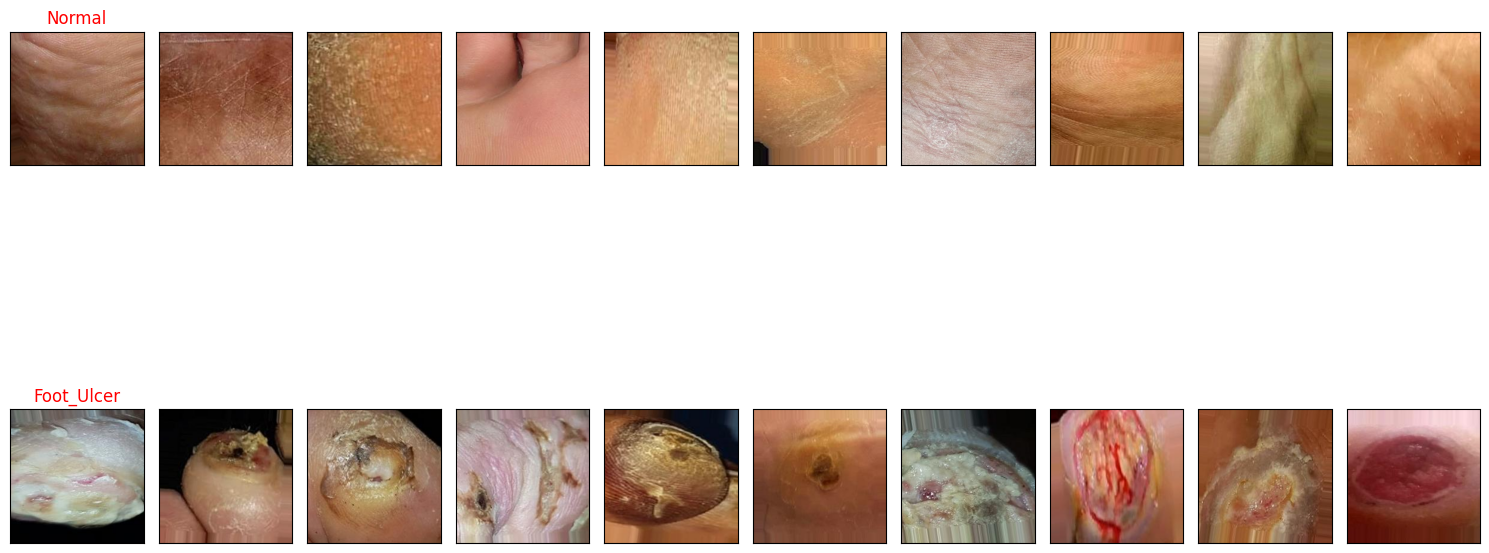

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)

        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

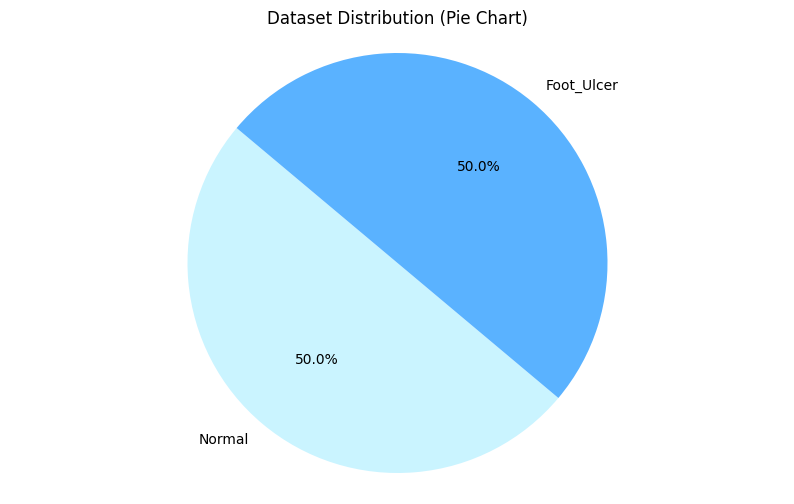

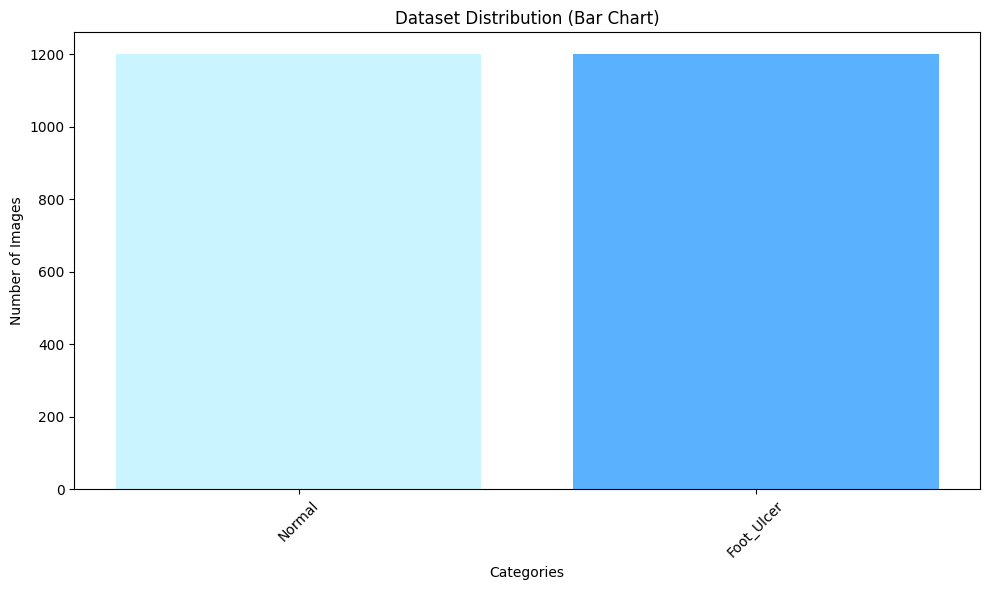

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


# Define custom colors
custom_colors = ['#CAF4FF','#5AB2FF','#99ff99']

# Plot pie chart
plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color=custom_colors)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 1200/1200 [00:18<00:00, 66.16it/s] 

2400


In [ ]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 300/300 [00:03<00:00, 81.25it/s] 

600


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (2400, 96, 96, 3) Y_train= (2400,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (600, 96, 96, 3) Y_test= (600,)


# DenseNet121

Epoch 1/10
75/75 [==============================] - 83s 158ms/step - loss: 0.2338 - accuracy: 0.9433 - val_loss: 0.8407 - val_accuracy: 0.8267
Epoch 2/10
75/75 [==============================] - 7s 89ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.4208 - val_accuracy: 0.8950
Epoch 3/10
75/75 [==============================] - 8s 103ms/step - loss: 0.0329 - accuracy: 0.9917 - val_loss: 0.4867 - val_accuracy: 0.9017
Epoch 4/10
75/75 [==============================] - 7s 91ms/step - loss: 0.0415 - accuracy: 0.9862 - val_loss: 0.2186 - val_accuracy: 0.9450
Epoch 5/10
75/75 [==============================] - 8s 105ms/step - loss: 0.0358 - accuracy: 0.9883 - val_loss: 0.0763 - val_accuracy: 0.9833
Epoch 6/10
75/75 [==============================] - 7s 90ms/step - loss: 0.0144 - accuracy: 0.9942 - val_loss: 0.0678 - val_accuracy: 0.9833
Epoch 7/10
75/75 [==============================] - 8s 104ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.8165 - val_accuracy: 0.7333
Epoch 8/

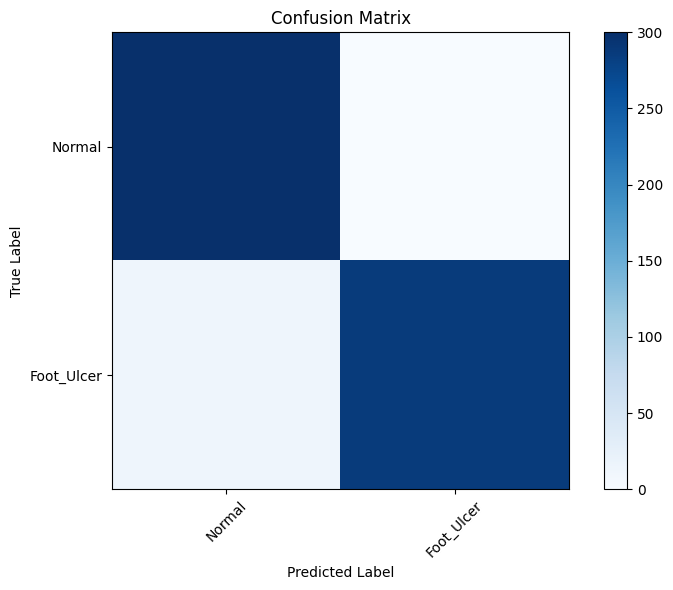

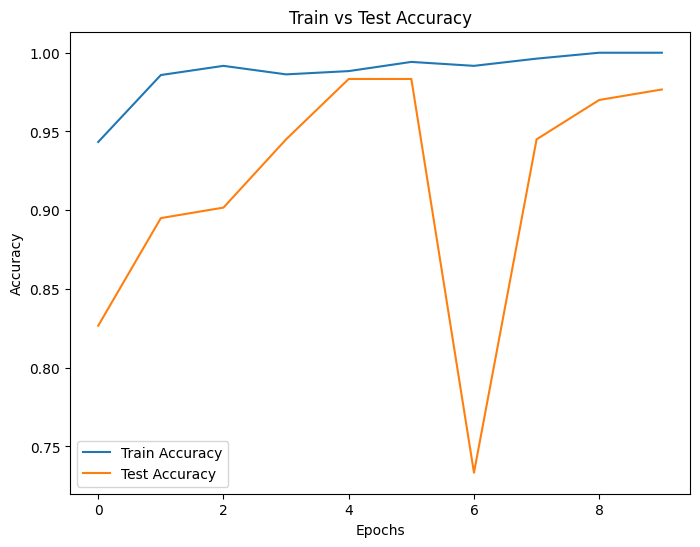

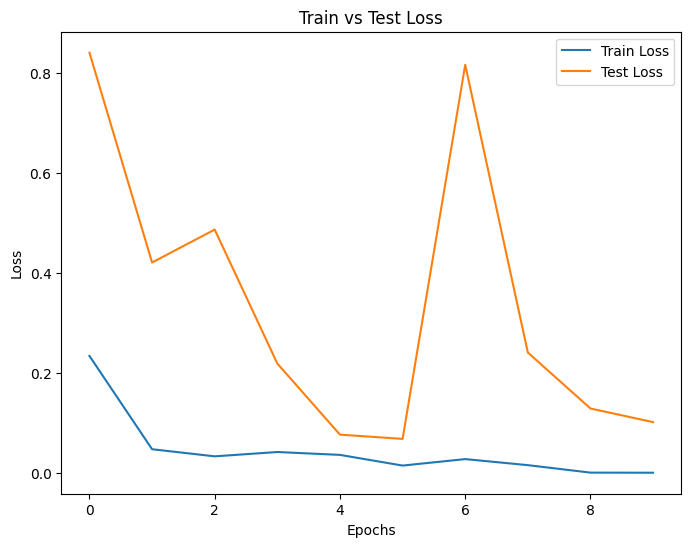

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

IMG_SIZE = 224
NUM_CLASSES = len(CATEGORIES)

# Load DenseNet121 with pre-trained ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add custom layers on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Plot confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CATEGORIES))
plt.xticks(tick_marks, CATEGORIES, rotation=45)
plt.yticks(tick_marks, CATEGORIES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Plot train vs test accuracy diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train vs test loss diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


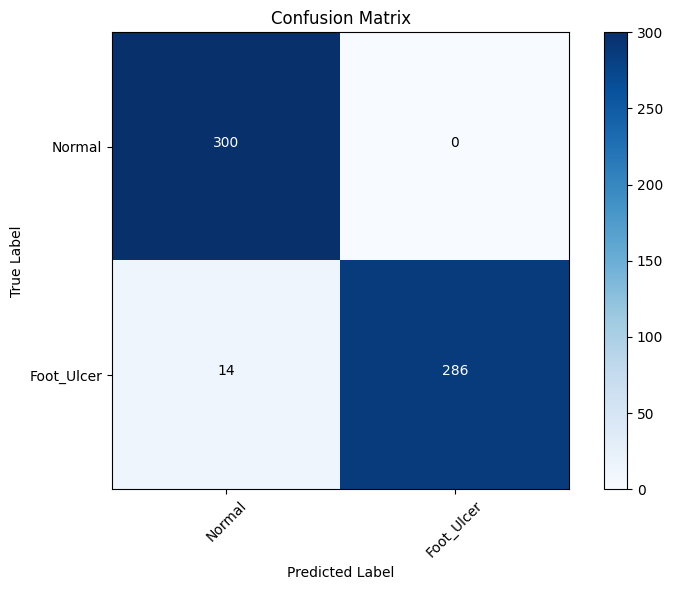

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CATEGORIES))
plt.xticks(tick_marks, CATEGORIES, rotation=45)
plt.yticks(tick_marks, CATEGORIES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add annotations
thresh = cm.max() / 2.
for i in range(len(CATEGORIES)):
    for j in range(len(CATEGORIES)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Print classification report
print(classification_report(Y_test, y_pred, target_names=CATEGORIES))


19/19 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       300
  Foot_Ulcer       1.00      0.95      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



# ResNet50

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
75/75 [==============================] - 43s 120ms/step - loss: 0.4733 - accuracy: 0.9417 - val_loss: 40.0378 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 7s 98ms/step - loss: 0.0532 - accuracy: 0.9846 - val_loss: 4.7825 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 7s 94ms/step - loss: 0.0438 - accuracy: 0.9871 - val_loss: 2.7716 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 7s 96ms/step - loss: 0.0332 - accuracy: 0.9912 - val_loss: 2.8250 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 7s 94ms/step - loss: 0.0251 - accuracy: 0.9929 - val_loss: 5.4403 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 7s 95ms/step - loss: 0.0293 - accuracy: 0.9912 - val_loss: 10.7875 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 8s 104ms/step - loss: 0.0024 - ac

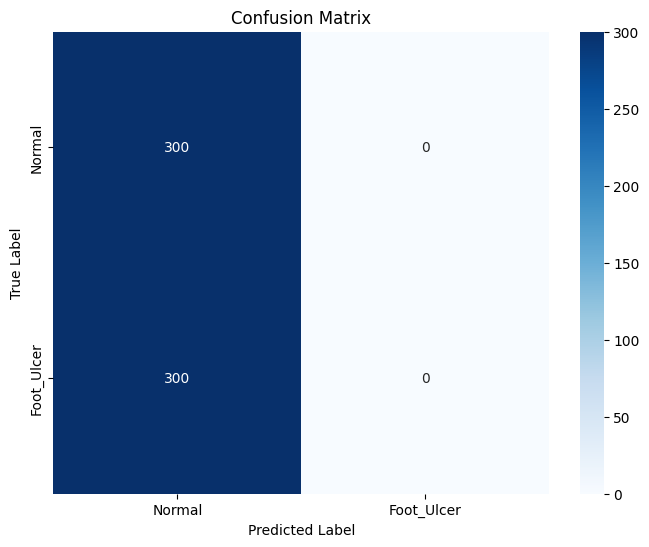

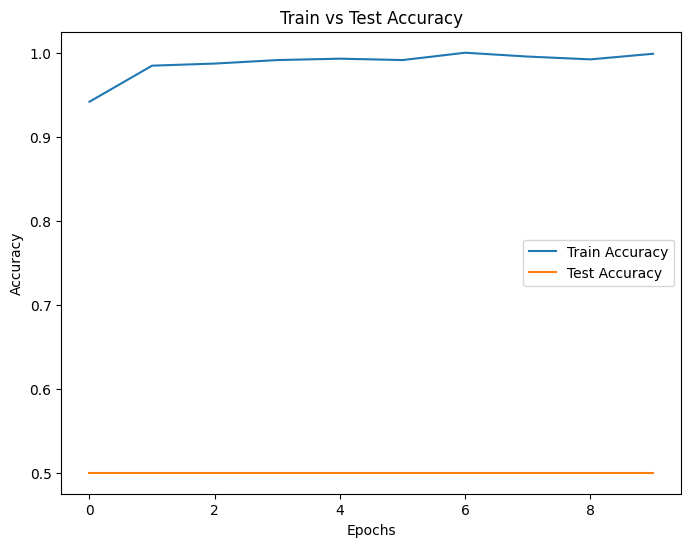

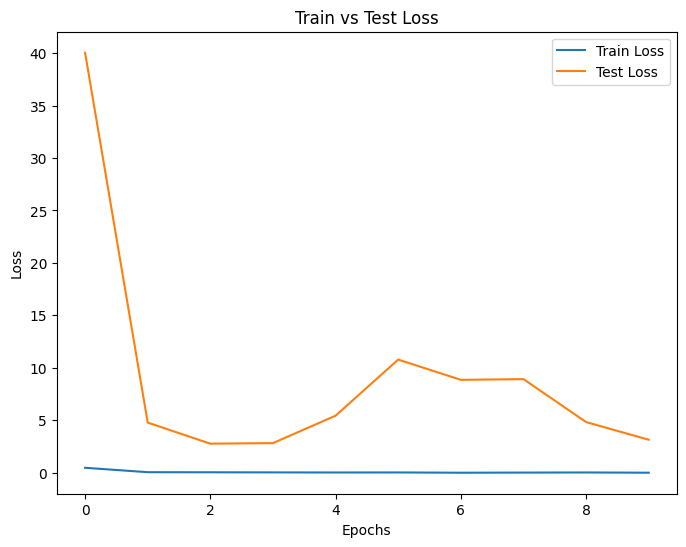

              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67       300
  Foot_Ulcer       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define constants
IMG_SIZE = 224
NUM_CLASSES = len(CATEGORIES)  # Assuming CATEGORIES is defined

# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot train vs test accuracy diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train vs test loss diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print classification report
print(classification_report(Y_test, y_pred, target_names=CATEGORIES))


# Inception V3

100%|██████████| 1200/1200 [00:31<00:00, 38.14it/s]


Number of training samples: 2400


100%|██████████| 300/300 [00:05<00:00, 56.28it/s]


Number of test samples: 600
X_train shape: (2400, 224, 224, 3), Y_train shape: (2400,)
X_test shape: (600, 224, 224, 3), Y_test shape: (600,)
Epoch 1/10
75/75 [==============================] - 53s 287ms/step - loss: 0.2013 - accuracy: 0.9375 - val_loss: 1.3193 - val_accuracy: 0.8000
Epoch 2/10
75/75 [==============================] - 21s 279ms/step - loss: 0.0867 - accuracy: 0.9742 - val_loss: 3.1986 - val_accuracy: 0.6067
Epoch 3/10
75/75 [==============================] - 19s 257ms/step - loss: 0.0517 - accuracy: 0.9842 - val_loss: 0.3606 - val_accuracy: 0.9400
Epoch 4/10
75/75 [==============================] - 20s 271ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 2.6960 - val_accuracy: 0.8600
Epoch 5/10
75/75 [==============================] - 20s 262ms/step - loss: 0.0625 - accuracy: 0.9800 - val_loss: 0.5257 - val_accuracy: 0.8867
Epoch 6/10
75/75 [==============================] - 21s 274ms/step - loss: 0.0451 - accuracy: 0.9837 - val_loss: 0.1411 - val_accuracy: 0.9583


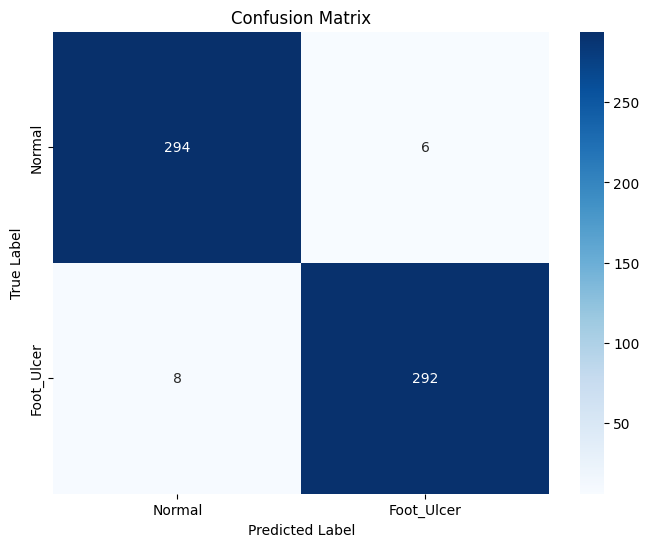

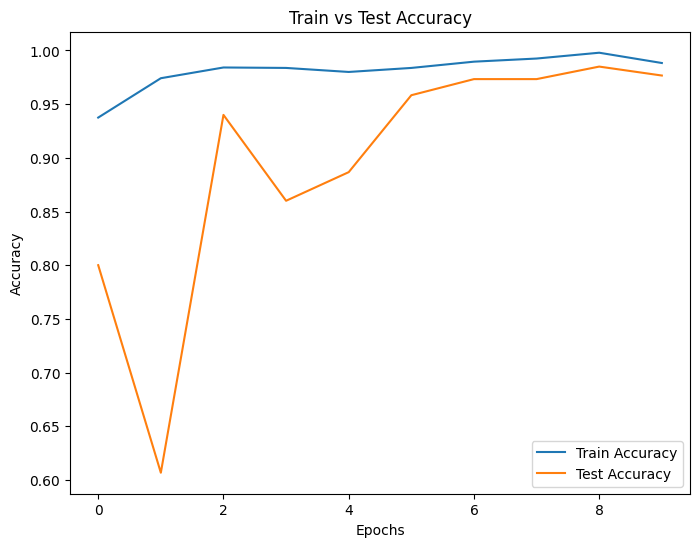

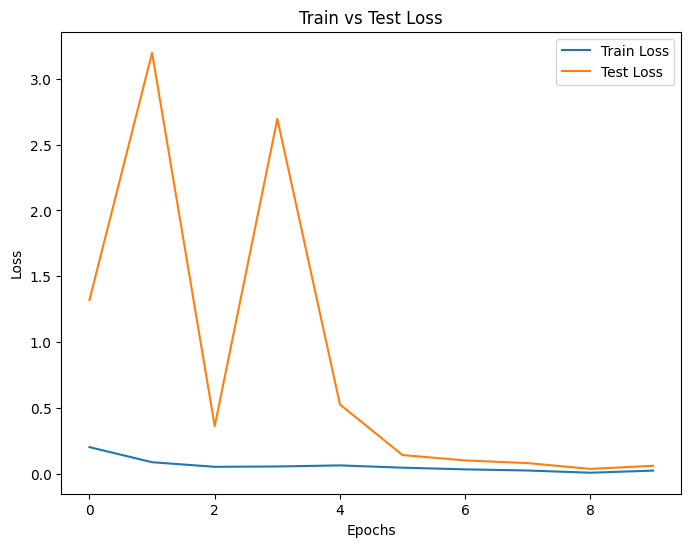

              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       300
  Foot_Ulcer       0.98      0.97      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define constants
IMG_SIZE = 224
NUM_CLASSES = len(CATEGORIES)  # Assuming CATEGORIES is defined

# Prepare training data
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(f"Number of training samples: {len(training_data)}")

# Prepare test data
test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(f"Number of test samples: {len(test_data)}")

# Split features and labels
X_train, Y_train = zip(*training_data)
X_test, Y_test = zip(*test_data)

# Convert to numpy arrays and normalize
X_train = np.array(X_train).astype('float32') / 255.0
Y_train = np.array(Y_train)
X_test = np.array(X_test).astype('float32') / 255.0
Y_test = np.array(Y_test)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Load Inception V3 with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers on top of Inception V3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot train vs test accuracy diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train vs test loss diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print classification report
print(classification_report(Y_test, y_pred, target_names=CATEGORIES))


# MobileNetV2

100%|██████████| 1200/1200 [00:06<00:00, 187.46it/s]


Number of training samples: 2400


100%|██████████| 300/300 [00:01<00:00, 169.39it/s]


Number of test samples: 600
X_train shape: (2400, 224, 224, 3), Y_train shape: (2400,)
X_test shape: (600, 224, 224, 3), Y_test shape: (600,)
Epoch 1/10
75/75 [==============================] - 43s 166ms/step - loss: 0.1548 - accuracy: 0.9550 - val_loss: 23.0946 - val_accuracy: 0.5567
Epoch 2/10
75/75 [==============================] - 10s 134ms/step - loss: 0.0523 - accuracy: 0.9850 - val_loss: 22.3241 - val_accuracy: 0.5633
Epoch 3/10
75/75 [==============================] - 10s 135ms/step - loss: 0.0359 - accuracy: 0.9900 - val_loss: 11.3654 - val_accuracy: 0.6567
Epoch 4/10
75/75 [==============================] - 10s 134ms/step - loss: 0.0403 - accuracy: 0.9862 - val_loss: 9.8617 - val_accuracy: 0.7467
Epoch 5/10
75/75 [==============================] - 10s 138ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 1.9387 - val_accuracy: 0.9100
Epoch 6/10
75/75 [==============================] - 10s 138ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 2.5978 - val_accuracy: 0.89

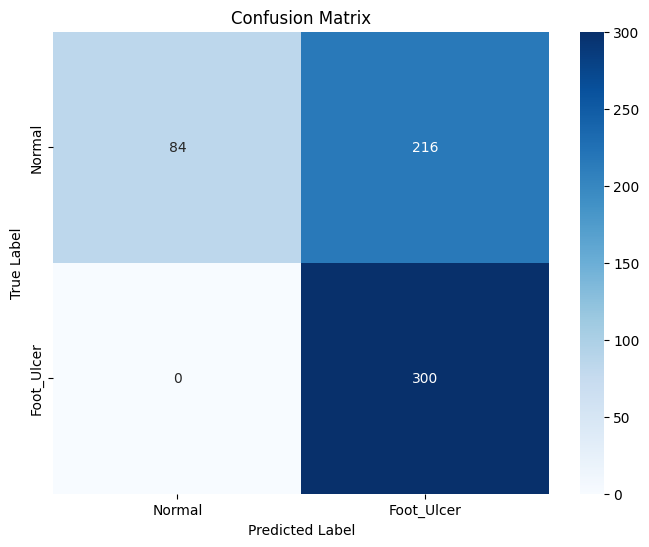

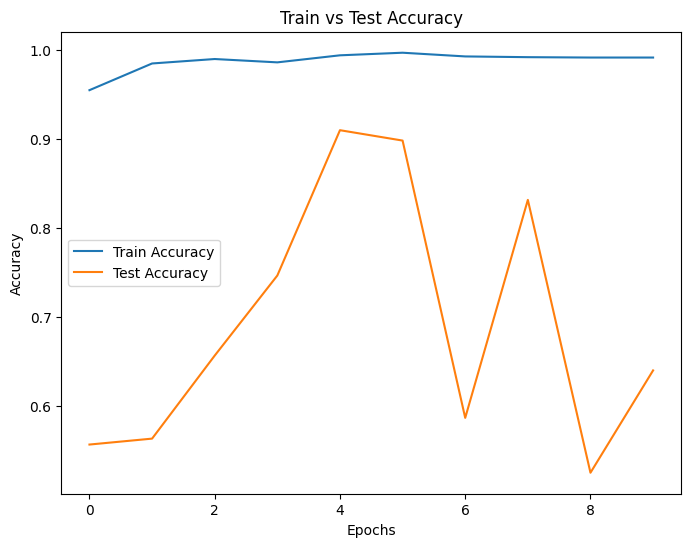

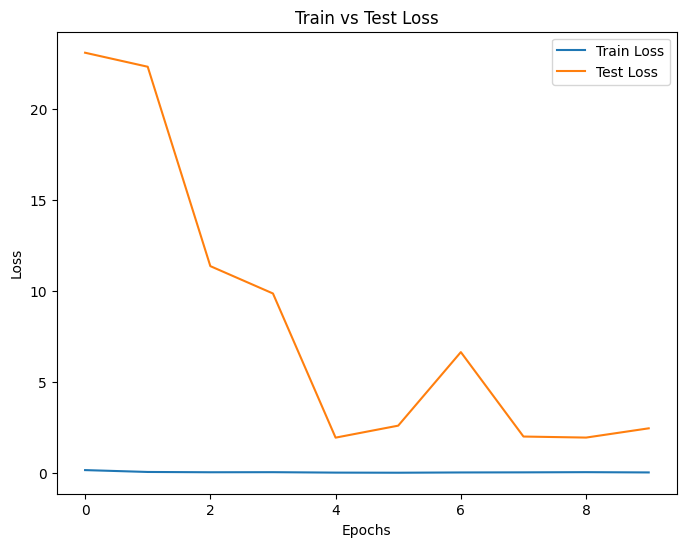

              precision    recall  f1-score   support

      Normal       1.00      0.28      0.44       300
  Foot_Ulcer       0.58      1.00      0.74       300

    accuracy                           0.64       600
   macro avg       0.79      0.64      0.59       600
weighted avg       0.79      0.64      0.59       600



In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define constants
IMG_SIZE = 224
NUM_CLASSES = len(CATEGORIES)  # Assuming CATEGORIES is defined

# Prepare training data
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(f"Number of training samples: {len(training_data)}")

# Prepare test data
test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(f"Number of test samples: {len(test_data)}")

# Split features and labels
X_train, Y_train = zip(*training_data)
X_test, Y_test = zip(*test_data)

# Convert to numpy arrays and normalize
X_train = np.array(X_train).astype('float32') / 255.0
Y_train = np.array(Y_train)
X_test = np.array(X_test).astype('float32') / 255.0
Y_test = np.array(Y_test)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Load MobileNetV2 with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot train vs test accuracy diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train vs test loss diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print classification report
print(classification_report(Y_test, y_pred, target_names=CATEGORIES))


# VGG16

100%|██████████| 1200/1200 [00:16<00:00, 70.73it/s] 


Number of training samples: 2400


100%|██████████| 300/300 [00:02<00:00, 117.92it/s]


Number of test samples: 600
X_train shape: (2400, 224, 224, 3), Y_train shape: (2400,)
X_test shape: (600, 224, 224, 3), Y_test shape: (600,)
Epoch 1/10
75/75 [==============================] - 61s 494ms/step - loss: 1.0247 - accuracy: 0.5038 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 32s 432ms/step - loss: 0.7095 - accuracy: 0.5425 - val_loss: 0.7308 - val_accuracy: 0.5217
Epoch 3/10
75/75 [==============================] - 32s 433ms/step - loss: 0.5182 - accuracy: 0.7225 - val_loss: 0.3245 - val_accuracy: 0.9550
Epoch 4/10
75/75 [==============================] - 33s 436ms/step - loss: 0.4101 - accuracy: 0.8163 - val_loss: 0.1574 - val_accuracy: 0.9483
Epoch 5/10
75/75 [==============================] - 33s 438ms/step - loss: 0.2511 - accuracy: 0.8992 - val_loss: 0.1261 - val_accuracy: 0.9583
Epoch 6/10
75/75 [==============================] - 33s 435ms/step - loss: 0.2079 - accuracy: 0.9204 - val_loss: 0.2011 - val_accuracy: 0.9317


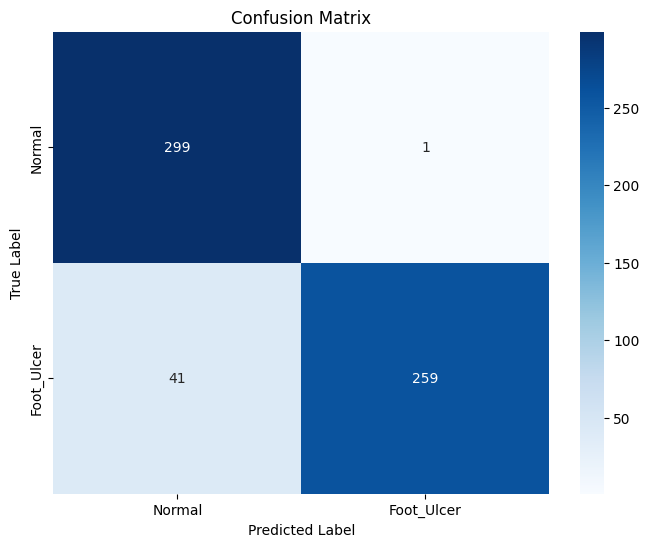

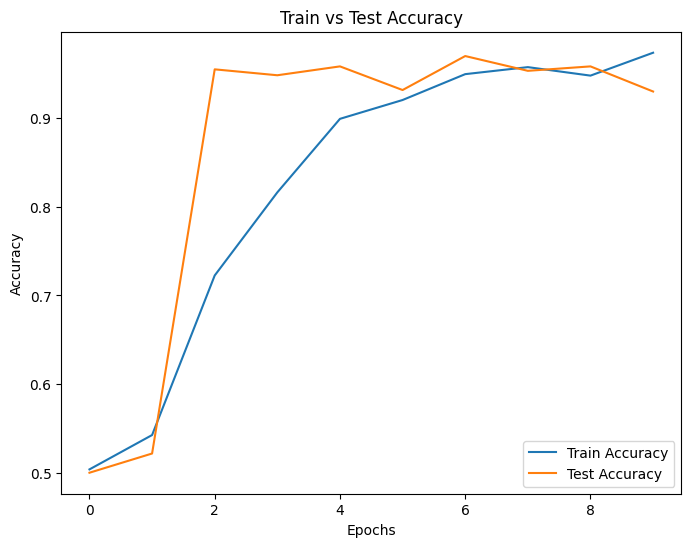

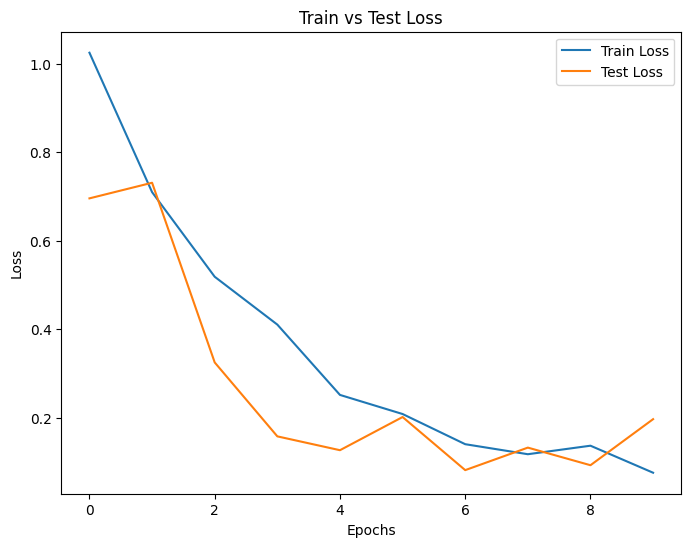

              precision    recall  f1-score   support

      Normal       0.88      1.00      0.93       300
  Foot_Ulcer       1.00      0.86      0.92       300

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600



In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define constants
IMG_SIZE = 224
NUM_CLASSES = len(CATEGORIES)

# Prepare training data
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(f"Number of training samples: {len(training_data)}")

# Prepare test data
test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(f"Number of test samples: {len(test_data)}")

# Split features and labels
X_train, Y_train = zip(*training_data)
X_test, Y_test = zip(*test_data)

# Convert to numpy arrays and normalize
X_train = np.array(X_train).astype('float32') / 255.0
Y_train = np.array(Y_train)
X_test = np.array(X_test).astype('float32') / 255.0
Y_test = np.array(Y_test)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Load VGG16 with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot train vs test accuracy diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train vs test loss diagram
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print classification report
print(classification_report(Y_test, y_pred, target_names=CATEGORIES))

# **Hybrid Model**


In [ ]:
pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


### Enet B0

In [ ]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

for layer in enet.layers:
    layer.trainable = False

# Build the model
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b0 = tf.keras.Model(inputs=enet.input, outputs=y)

# Compile the model
e_model_b0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
e_model_b0.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 48, 48, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  

In [ ]:
efficientnet_b0 = e_model_b0.fit(x=X_train, y=Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/200
38/38 [==============================] - 25s 280ms/step - loss: 0.2202 - accuracy: 0.9250 - val_loss: 0.0309 - val_accuracy: 0.9850
Epoch 2/200
38/38 [==============================] - 2s 46ms/step - loss: 0.0580 - accuracy: 0.9775 - val_loss: 0.0266 - val_accuracy: 0.9900
Epoch 3/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0353 - accuracy: 0.9862 - val_loss: 0.0253 - val_accuracy: 0.9950
Epoch 4/200
38/38 [==============================] - 2s 46ms/step - loss: 0.0206 - accuracy: 0.9917 - val_loss: 0.0298 - val_accuracy: 0.9883
Epoch 5/200
38/38 [==============================] - 2s 61ms/step - loss: 0.0219 - accuracy: 0.9908 - val_loss: 0.0327 - val_accuracy: 0.9917
Epoch 6/200
38/38 [==============================] - 2s 63ms/step - loss: 0.0267 - accuracy: 0.9929 - val_loss: 0.0272 - val_accuracy: 0.9933
Epoch 7/200
38/38 [==============================] - 2s 52ms/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.0292 - val_accuracy: 0.9933
Epoc

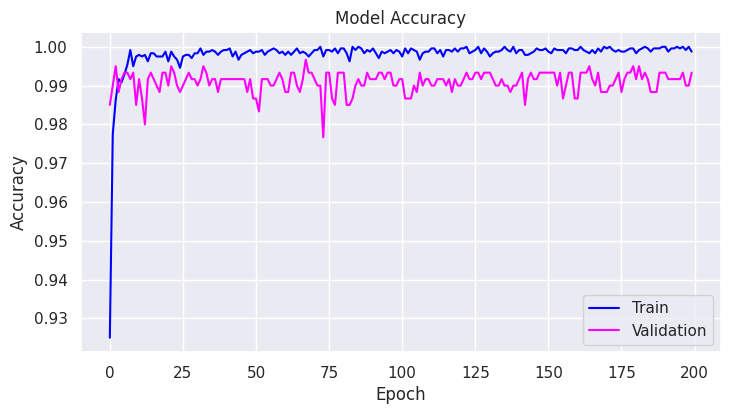

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b0.history['accuracy'], color="blue")
plt.plot(efficientnet_b0.history['val_accuracy'] , color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

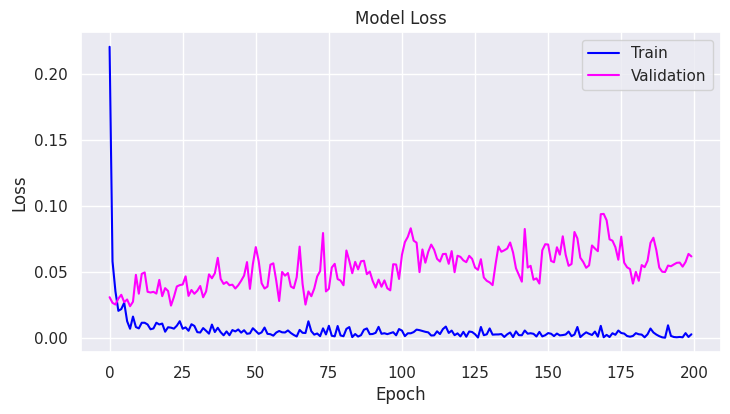

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b0.history['loss'], color="blue")
plt.plot(efficientnet_b0.history['val_loss'], color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
from sklearn.svm import SVC

features_train = e_model_b0.predict(X_train)
features_test = e_model_b0.predict(X_test)
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)
svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(features_train_flat, Y_train)

19/19 [==============================] - 2s 19ms/step


SVC(gamma='auto')

In [ ]:


train_accuracy = svm.score(features_train_flat, Y_train)
print(f"Train Accuracy: {train_accuracy}")

test_accuracy = svm.score(features_test_flat, Y_test)
print(f"Test Accuracy: {test_accuracy}")


if Y_train.ndim == 2:
    Y_train_integer = np.argmax(Y_train, axis=1)
else:
    Y_train_integer = Y_train

if Y_test.ndim == 2:
    Y_test_integer = np.argmax(Y_test, axis=1)
else:
    Y_test_integer = Y_test

train_loss = hinge_loss(Y_train_integer, svm.decision_function(features_train_flat))
print(f"Train Loss: {train_loss}")

test_loss = hinge_loss(Y_test_integer, svm.decision_function(features_test_flat))
print(f"Test Loss: {test_loss}")

Train Accuracy: 1.0
Test Accuracy: 0.9933333333333333
Train Loss: 1.378078985332191e-07
Test Loss: 0.017336231024167405


In [ ]:
print("Number of features expected by the model:", svm.n_features_in_)

Number of features expected by the model: 2


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = svm.predict(features_test_flat)
y_true = np.argmax(Y_test, axis=0)
print(y_pred)
print(y_pred.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[296,   4],
       [  0, 300]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=7,target_names = CATEGORIES))

              precision    recall  f1-score   support

  Foot_Ulcer  1.0000000 0.9866667 0.9932886       300
      Normal  0.9868421 1.0000000 0.9933775       300

    accuracy                      0.9933333       600
   macro avg  0.9934211 0.9933333 0.9933330       600
weighted avg  0.9934211 0.9933333 0.9933330       600



In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

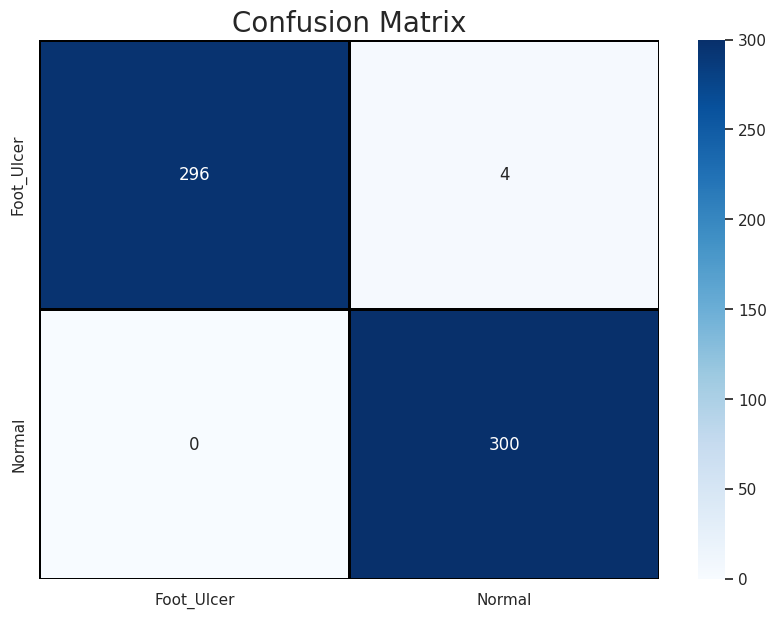

In [ ]:
plt.figure(figsize = (10,7))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

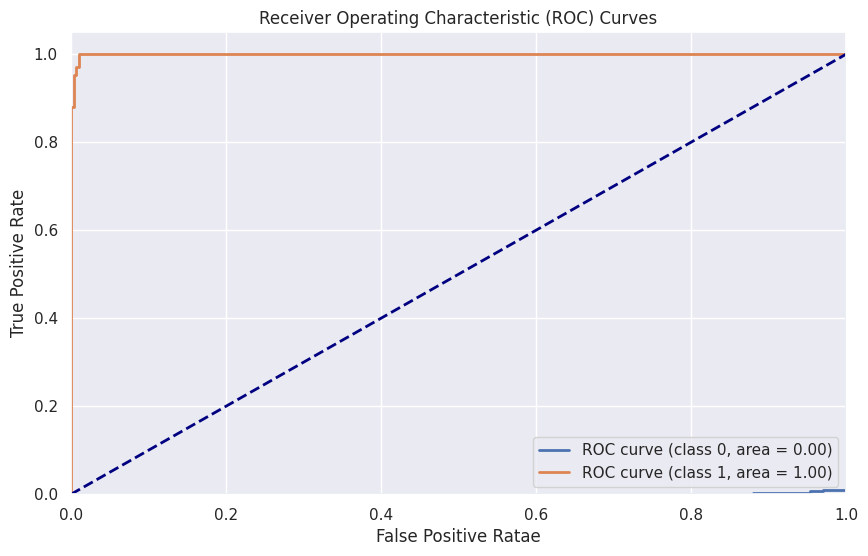

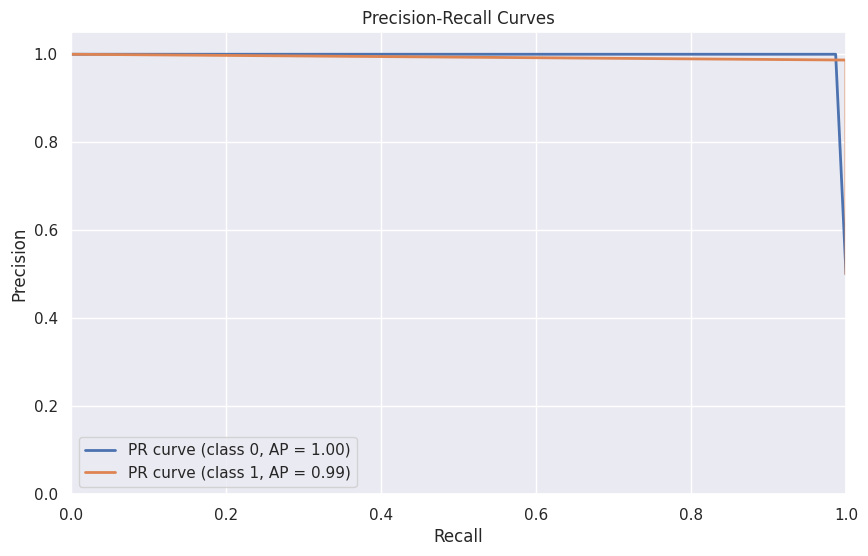

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

svm_output_probs = svm.decision_function(features_test_flat)
svm_output = svm.predict(features_test_flat)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, svm_output_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, svm_output == i)
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Ratae')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()
